In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

import surface
import grid 
import heston
import heston_lsv

## 1. Create grids for local volatility and Pricer

In [3]:
#Pricing grid
target_grid = grid.Grid()
grid_strikes = np.array([0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4])
grid_maturities = np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.])
target_grid.fixed_grid_generate(grid_strikes, grid_maturities, 100)

#local volaitlity grid
grid_loc = grid.Grid()
loc_strikes = np.array([0.65,1.0,1.35])
loc_maturities = np.array([0.35, 1.25, 2])
grid_loc.fixed_grid_generate(loc_strikes, loc_maturities, 100)

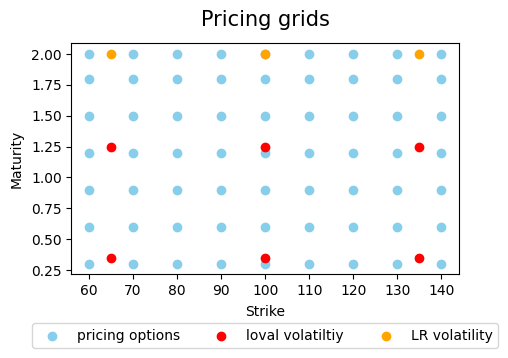

In [4]:
#Plot
plt.figure(1,figsize=(5,3))
plt.title("Pricing grids",fontsize=15,y=1.04)
plt.scatter(target_grid.strikes, target_grid.maturities, label = 'pricing options', color = 'skyblue')
plt.scatter(grid_loc.strikes[:6], grid_loc.maturities[:6], label = 'loval volatiltiy', c = 'r')
plt.scatter(grid_loc.strikes[6:], grid_loc.maturities[6:], label = 'LR volatility', c = 'orange')
plt.xlabel("Strike",fontsize=10,labelpad=5)
plt.ylabel("Maturity",fontsize=10,labelpad=5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=5)
plt.savefig("grid.pdf", format="pdf", bbox_inches="tight")

## 2. Pricing using Heston model

In [6]:
#CREATE MODEL 
params = [0.9,  3.45,  0.055,  0.035, -0.5]
qe_params = [1.50, 0.50, 0.50]
model = heston.Heston(params, 100, 0.05, qe_params)

#PROVIDE PRICING
#EULER
pth = model.euler_scheme(N = 1000, T = 2, n = 100, seed_ = 1965)
price_euler = model.mc_price(target_grid.strikes, target_grid.maturities, True)

#Quadratic exponential ANDERSEN
pth = model.qe_a_scheme(N = 1000, T = 2, n = 100, seed_ = 1965)
price_qe = model.mc_price(target_grid.strikes, target_grid.maturities, True)

#BROADIE KAYA
pth = model.broadie_kaya_scheme(N = 1000, T = 2, n = 100, seed_ = 1965)
price_broadie = model.mc_price(target_grid.strikes, target_grid.maturities, True)

#ANALYTIC LEWIS PRICING
price_analytic = model.analytic_price(target_grid.strikes, target_grid.maturities, True, 'lewis')

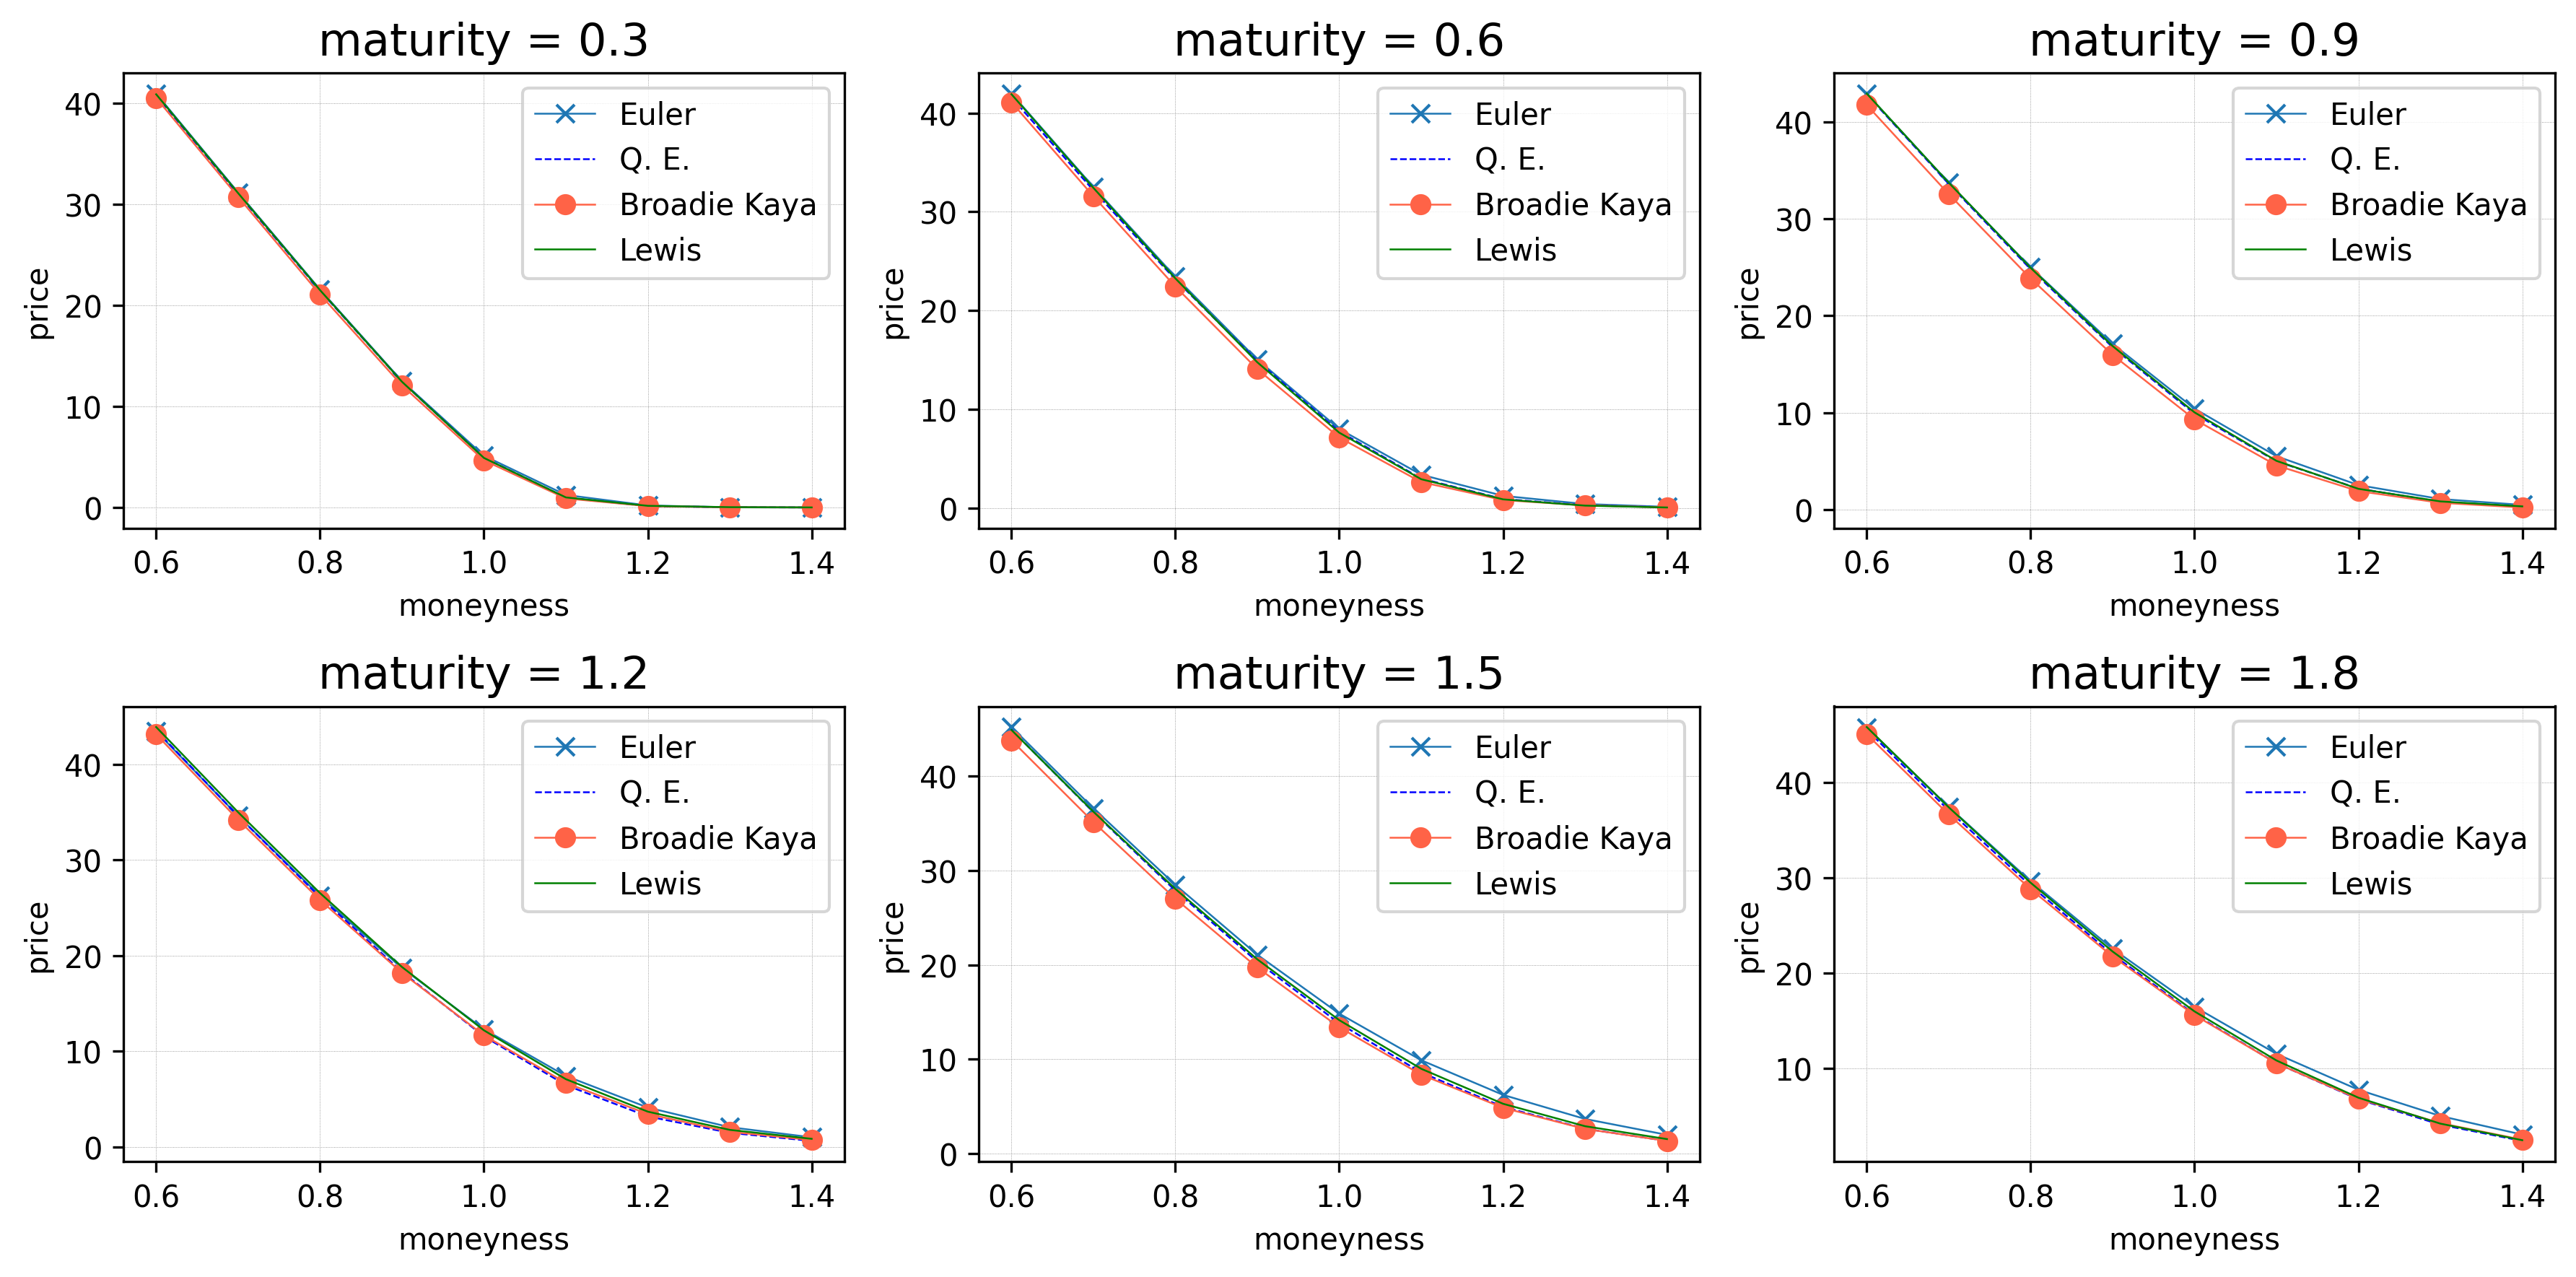

In [7]:
#Plot prices
plt.figure(1, figsize=(12,6), dpi=300)
for i in range(0,6): 
    ax = plt.subplot(2, 3, i + 1)
    mat = grid_maturities[i]
    plt.title("maturity = " + str(mat), fontsize=15)
    indices = np.where(target_grid.maturities == mat)
    plt.plot(grid_strikes, price_euler[indices], 'x-', linewidth=0.6, label = 'Euler')
    plt.plot(grid_strikes, price_qe[indices], 'b--', linewidth=0.6, label = 'Q. E.')
    plt.plot(grid_strikes, price_broadie[indices], 'o-', linewidth=0.6, label = 'Broadie Kaya', color = 'tomato')
    plt.plot(grid_strikes, price_analytic[indices], '-', linewidth=0.6, label = 'Lewis', color='g')
    plt.xlabel("moneyness",fontsize=10)
    plt.ylabel("price",fontsize=10)
    plt.legend()
    plt.grid(color = 'grey', linestyle = ':', linewidth = 0.2)

plt.tight_layout()
plt.savefig("pure_heson_pricing.pdf", format="pdf", bbox_inches="tight")

## 3. Pricing using Heston LSV with discrete local volatility

In [5]:
#set Heston parameters
params = [0.3,  3.45,  0.055,  0.035, -0.5]
qe_params = [1.50, 0.50, 0.50]

#set local volatilitties
vol =  [0.22, 0.10, 0.2, 0.5, 0.2, 0.2, np.sqrt(0.055), np.sqrt(0.055), np.sqrt(0.055)]
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, vol))

#set bins for E(Vt|S = St) approximation
bins = np.linspace(50, 160, 20)

#CREATE MODEL
lsv_model = heston_lsv.HestonLSV(params, 100, 0.05, qe_params, bins)
lsv_model.set_bump(bump)

#PROVIDE PRICING
#EULER scheme
pth = lsv_model.euler_scheme(N = 10_000, T = 2, n = 100, seed_ = 1)
price_lsv_euler = lsv_model.mc_price(target_grid.strikes, target_grid.maturities, True)

#BROADIE KAYA scheme
pth = lsv_model.broadie_kaya_scheme(N = 10_000, T = 2, n = 100, seed_ = 1)
price_lsv_broadie = lsv_model.mc_price(target_grid.strikes, target_grid.maturities, True)

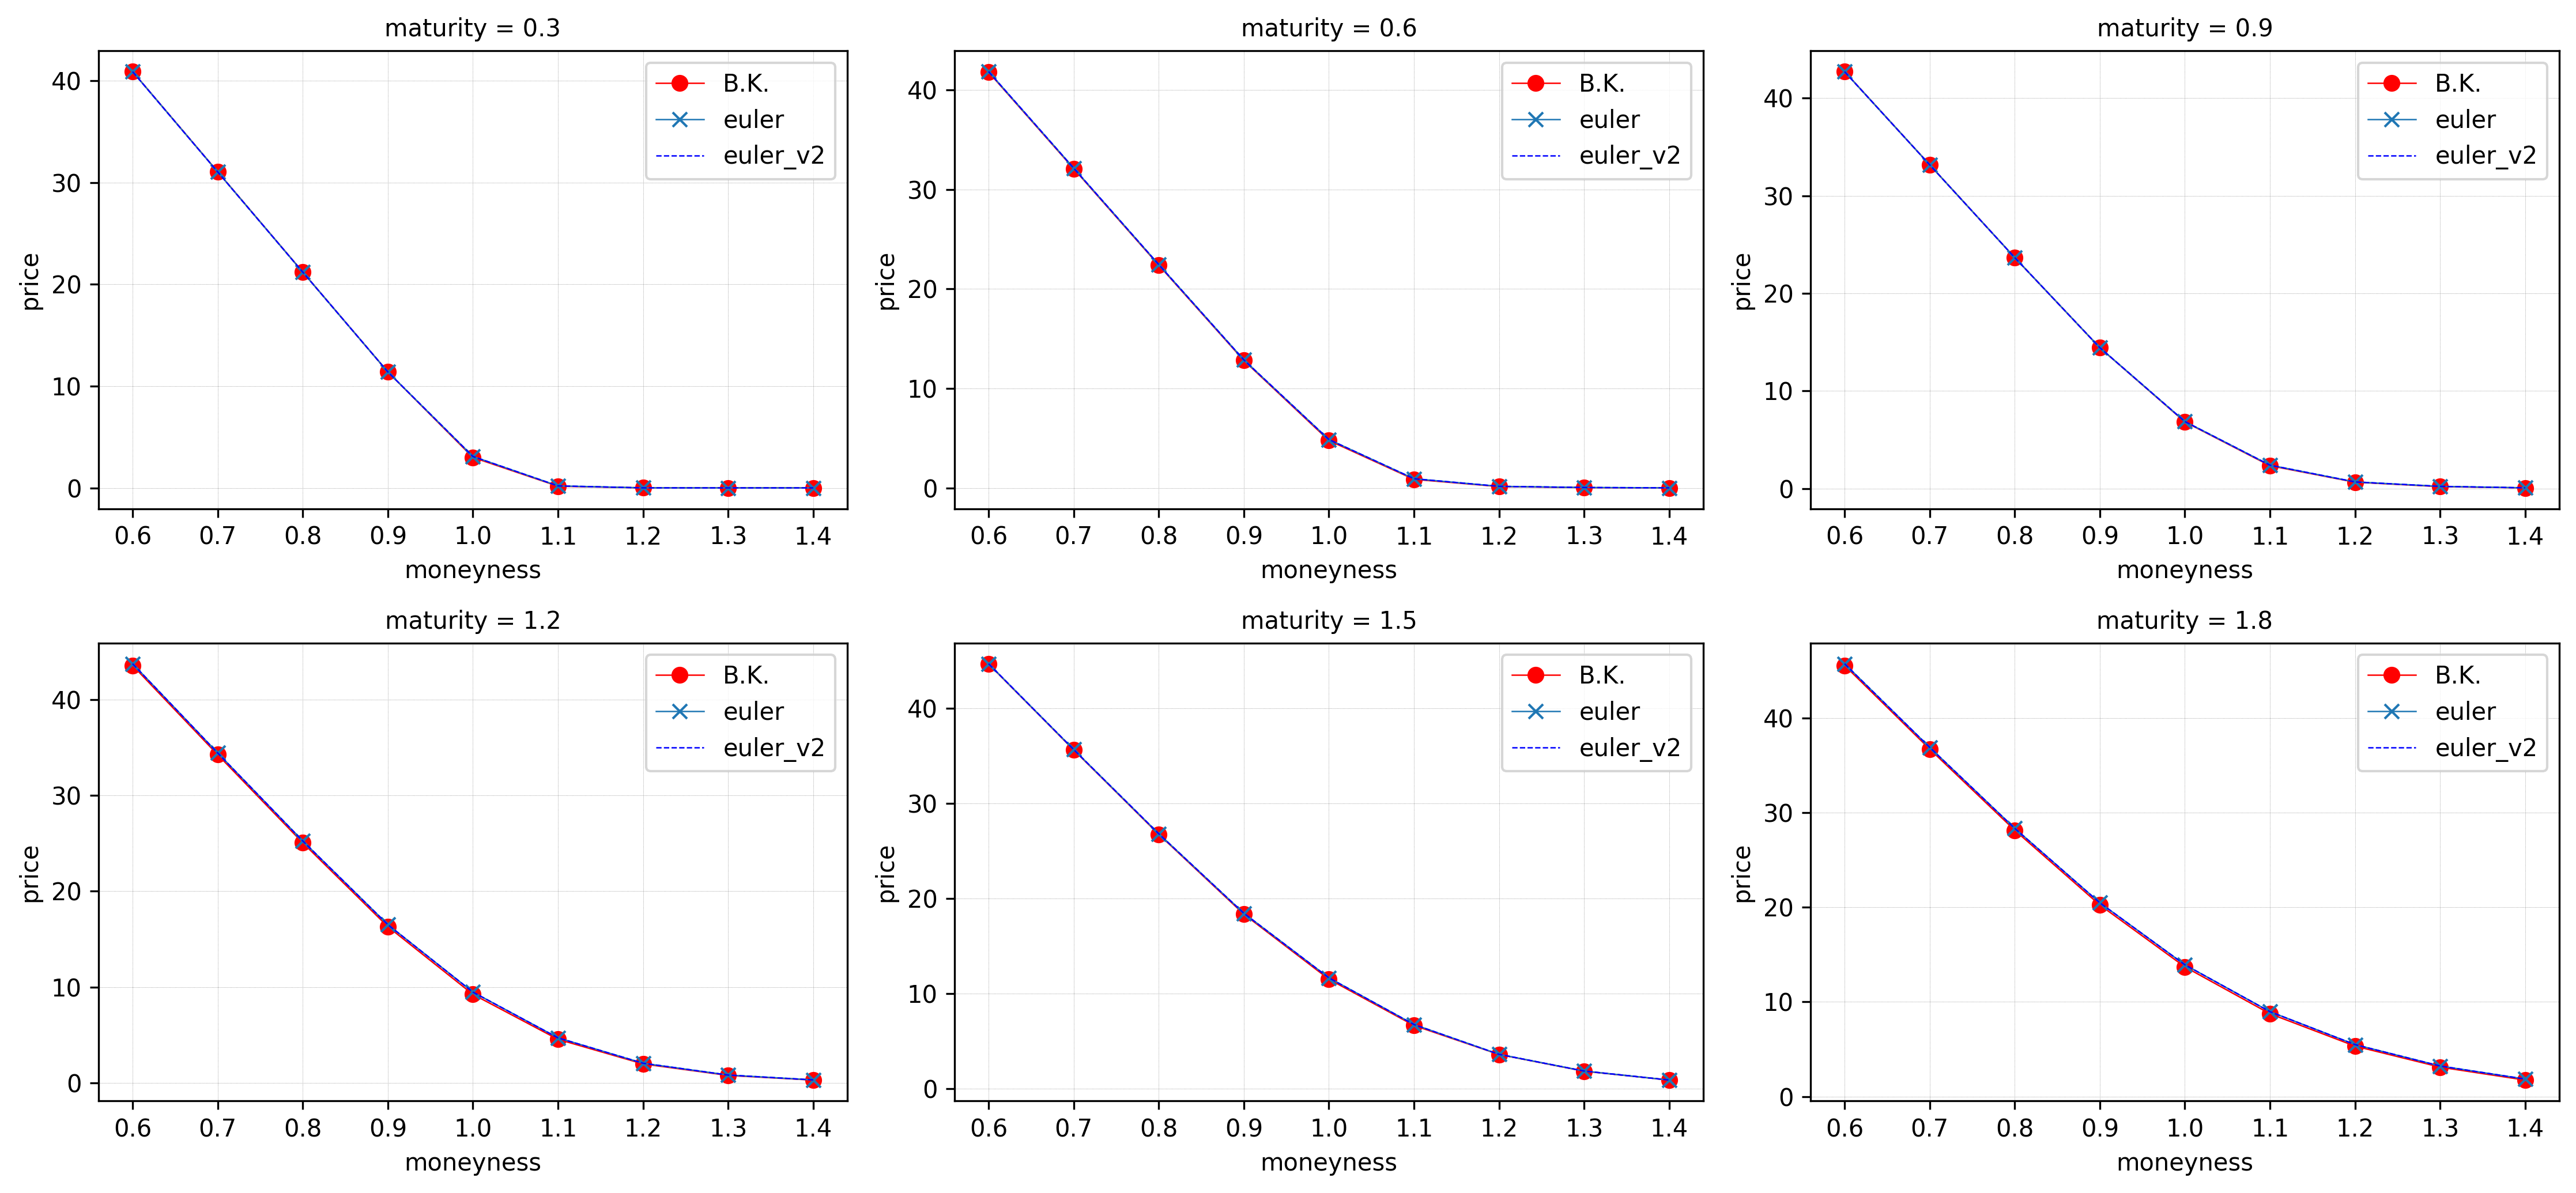

In [6]:
#Plot prices: 

plt.figure(1, figsize = (15, 7), dpi = 300)
for i in range(0,6): 
    ax = plt.subplot(2, 3, i + 1)
    mat = grid_maturities[i]
    plt.title("maturity = " + str(mat), fontsize = 10)
    indices = np.where(target_grid.maturities == mat)
    plt.plot(grid_strikes, price_lsv_broadie[indices], 'o-', linewidth=0.6, label = 'B.K.', color = 'r')
    plt.plot(grid_strikes, price_lsv_euler[indices], 'x-', linewidth=0.6, label = 'euler')
    plt.plot(grid_strikes, price_lsv_euler_v2[indices], 'b--', linewidth=0.6, label = 'euler_v2')
    plt.xlabel("moneyness",fontsize=10)
    plt.ylabel("price",fontsize=10)
    plt.legend()
    plt.grid(color = 'grey', linestyle = ':', linewidth = 0.2)

plt.tight_layout()

In [50]:
#BUMPING PARTICULAR SET OF PARAMETERS
params = [0.38,  1.3253,  0.0354, 0.0174, -0.7165]
new_lsv_model = heston_lsv.HestonLSV(params, 100, 0, qe_params, bins)
new_lsv_model.set_bump(bump)

#Application of BUMP parameters combinations:
vol = [0.05, 0.1,  0.05,  0.01,  0.1, 0.01,  np.sqrt(0.0354), np.sqrt(0.0354), np.sqrt(0.0354)]
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, vol))
new_lsv_model.set_bump(bump)
pth = new_lsv_model.broadie_kaya_scheme(N = 1000, T = 2, n = 250, seed_ = 1)
price_mc_low = new_lsv_model.mc_price(target_grid.strikes, target_grid.maturities, True)

vol = [0.2, 0.2,  0.2,  0.35,  0.25, 0.35,  np.sqrt(0.0354), np.sqrt(0.0354), np.sqrt(0.0354)]
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, vol))
new_lsv_model.set_bump(bump)
pth = new_lsv_model.broadie_kaya_scheme(N = 1000, T = 2, n = 250, seed_ = 1)
price_mc_high = new_lsv_model.mc_price(target_grid.strikes, target_grid.maturities, True)

vol = [0.5, np.sqrt(0.0174),  0.1,  0.6,  0.2, 0.1,  np.sqrt(0.0354), np.sqrt(0.0354), np.sqrt(0.0354)]
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, vol))
new_lsv_model.set_bump(bump)
pth = new_lsv_model.broadie_kaya_scheme(N = 1000, T = 2, n = 250, seed_ = 1)
price_mc_side1 = new_lsv_model.mc_price(target_grid.strikes, target_grid.maturities, True)

vol = [0.1, np.sqrt(0.0174),  0.5,  0.1,  0.2, 0.6, np.sqrt(0.0354), np.sqrt(0.0354), np.sqrt(0.0354)]
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, vol))
new_lsv_model.set_bump(bump)
pth = new_lsv_model.broadie_kaya_scheme(N = 1000, T = 2, n = 250, seed_ = 1)
price_mc_side2 = new_lsv_model.mc_price(target_grid.strikes, target_grid.maturities, True)

#Comparison wth Pure Heston model 
#ANALYTIC LEWIS PRICING
model = heston.Heston(params, 100, 0.0, qe_params)
price_analytic = model.analytic_price(target_grid.strikes, target_grid.maturities, True, 'lewis')

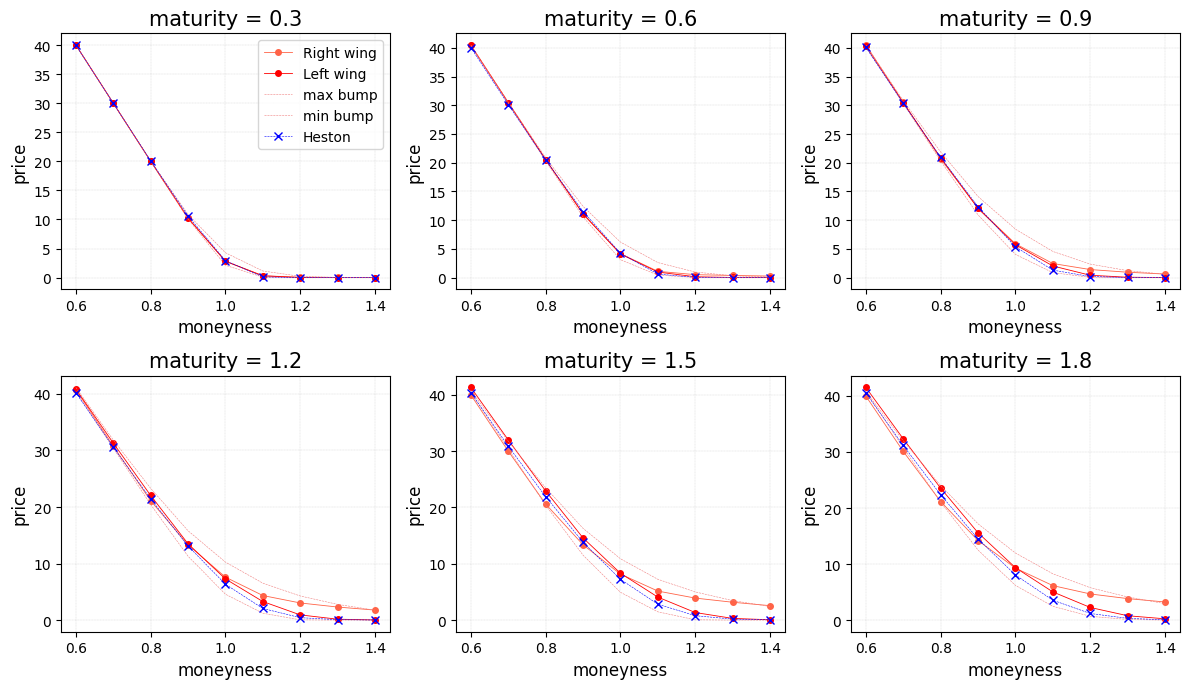

In [68]:
#Plot prices
plt.figure(1, figsize=(12, 7))

for i in range(0,6): 
    ax = plt.subplot(2, 3, i + 1)
    mat = grid_maturities[i]
    plt.title("maturity = " + str(mat), fontsize = 15)
    indices = np.where(target_grid.maturities == mat)
    plt.plot(grid_strikes, price_mc_side2[indices], 'o-', linewidth=0.6, label = 'Right wing', color = 'tomato', markersize = 4)
    plt.plot(grid_strikes, price_mc_side1[indices], 'o-', linewidth=0.6, label = 'Left wing', color = 'r', markersize = 4)
    plt.plot(grid_strikes, price_mc_high[indices] ,'--', c = 'lightcoral', label = 'max bump', linewidth=0.4)
    plt.plot(grid_strikes, price_mc_low[indices],'--', c = 'lightcoral', label = 'min bump', linewidth=0.4)
    plt.plot(grid_strikes, price_analytic[indices],'x--', c = 'blue', label = 'Heston', linewidth=0.4)
    plt.xlabel("moneyness",fontsize=12)
    plt.ylabel("price",fontsize=12)
    if i == 0: 
        plt.legend()
    plt.grid(color = 'grey', linestyle = ':', linewidth = 0.2)

plt.tight_layout()

plt.savefig("LSV_pricing.pdf", format="pdf", bbox_inches="tight")

## 4. Monte-Carlo simulation of the Heston LSV with discrete local volatility 

In [18]:
def LSV_simulation_euler(bump, bins, params, s0, r, N, T, n, seed_):
    sigma, kappa, theta, v0, rho = params
    dt = 1 / n  # Time step

    stockpaths = np.ones((N, T * n + 1)) * s0
    volpaths = np.ones((N, T * n + 1)) * v0
    stochastic_component = np.ones((N, n * T + 1)) * v0
    local_component = np.ones((N, n * T + 1)) * v0
    LSV_volatility = np.ones((N, n * T + 1)) * v0

    X = np.stack((bump[0], bump[1]), axis = 1) 
    Y = np.array(bump[2]) ** 2

    # Brownian motions
    np.random.seed(seed_)
    dW1 = np.random.normal(0, np.sqrt(dt), (N, n * T))
    dW2 = rho * dW1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt), (N, n * T))

    for i in range(1, T * n + 1):

        volpaths[:, i] = (volpaths[:, i - 1] + kappa * (theta - np.maximum(volpaths[:, i-1], 0)) * dt + 
                          sigma * np.sqrt(np.maximum(volpaths[:, i-1], 0)) * dW1[:, i-1])
        
        volpaths[:, i] = np.maximum(volpaths[:, i], 0)
        
        stockpaths[:, i] = (stockpaths[:, i-1] * (1 + r * dt + 
                            np.sqrt(volpaths[:, i - 1]) * 
                            np.sqrt((local_component[:, i - 1]) / stochastic_component[:, i - 1]) * 
                            dW2[:, i-1]))

        stock_time_pairs = np.array(list(zip(stockpaths[:, i], np.ones(N) * (i / n))))
        distances = cdist(X, stock_time_pairs, 'euclidean').T
        min_indices = np.argmin(distances, axis=1)
        local_component[:, i] = Y[min_indices]

        collection = np.digitize(stockpaths[:, i], bins, right = False) 
        for g in np.unique(collection):
            indices = np.where(collection == g)
            stochastic_component[:, i][indices] = np.mean([volpaths[:, i][indices]])

            
        LSV_volatility[:, i] = volpaths[:, i] * local_component[:, i] / stochastic_component[:, i]

    return stockpaths, volpaths, stochastic_component, local_component, LSV_volatility

In [47]:
#PARAMETERS
#set Heston parameters
params = [0.38,  10,  0.0354, 0.0174, -0.7165]
qe_params = [1.50, 0.50, 0.50]

#set local volatilitties
vol =  [0.22, 0.1,  0.2,  0.23,  0.2,  0.2, np.sqrt( 0.0354), np.sqrt( 0.0354), np.sqrt( 0.0354)]
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, vol))

#set bins for E(Vt|S = St) approximation
bins = np.linspace(50, 160, 20)

#PROVIDE PRICING
#without bump:
model = heston.Heston(params, 100, 0.05, qe_params)
pure_stock, pure_vols = model.euler_scheme(N = 10_000, T = 2, n = 100, seed_ = 1965)

#with bump:
bump_stock, bump_vols, bump_EV, bump_Vloc, bump_lsv_vol = LSV_simulation_euler(bump, bins, params, s0 = 100, r = 0.05, N = 10_000, T = 2, n = 100, seed_ = 1965)

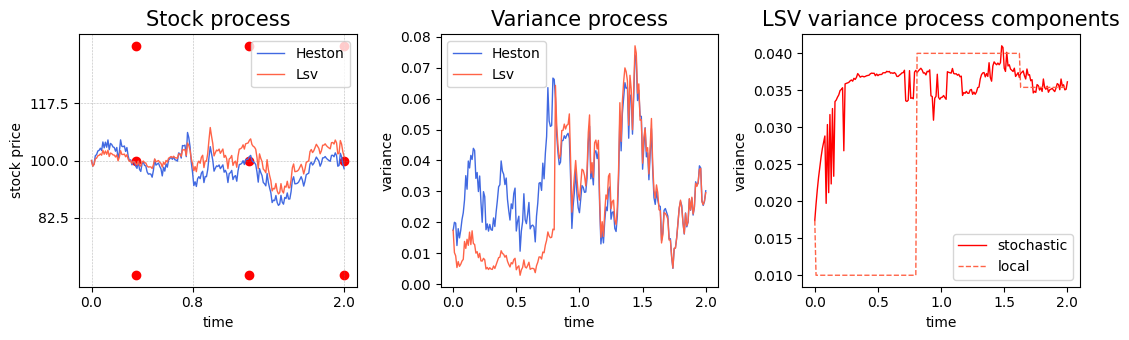

In [48]:
#Plot the sample path: 

x_ = np.linspace(0, 2, 2 * 100 + 1)
i = 4
fig, axs = plt.subplots(1, 3, figsize=(11,3.5))

axs[0].plot(x_, pure_stock[i], label='Heston', color = 'royalblue', linewidth=1)
axs[0].plot(x_, bump_stock[i], label='Lsv',  color = 'tomato', linewidth=1)
axs[0].legend()
axs[0].set_title('Stock process' ,fontsize=15)
axs[0].set_ylabel('stock price' ,fontsize=10)
axs[0].scatter(grid_loc.maturities, grid_loc.strikes, label = 'loval volatiltiy', c = 'r')
axs[0].set_xticks([0, 0.8, 2])
axs[0].set_yticks([82.5, 100, 117.5])
axs[0].grid(color = 'grey', linestyle = ':', linewidth = 0.4)
axs[0].set_xlabel('time' ,fontsize=10)

# Second subplot
axs[1].plot(x_, pure_vols[i], label='Heston', color = 'royalblue',linewidth=1)
axs[1].plot(x_, bump_lsv_vol[i], label='Lsv',  color = 'tomato', linewidth=1)
axs[1].legend()
axs[1].set_title('Variance process' ,fontsize=15)
axs[1].set_ylabel('variance' ,fontsize=10)
axs[1].set_xlabel('time' ,fontsize=10)

axs[2].plot(x_, bump_EV[i], label='stochastic', color = 'red', linewidth=1)
axs[2].plot(x_, bump_Vloc[i],'--', label='local', color = 'tomato', linewidth=1)

axs[2].legend()
axs[2].set_title('LSV variance process components' ,fontsize=15)
axs[2].set_ylabel('variance',fontsize=10)
axs[2].set_xlabel('time' ,fontsize=10)
plt.tight_layout()
plt.savefig("path_example.pdf", format="pdf", bbox_inches="tight")
plt.show()


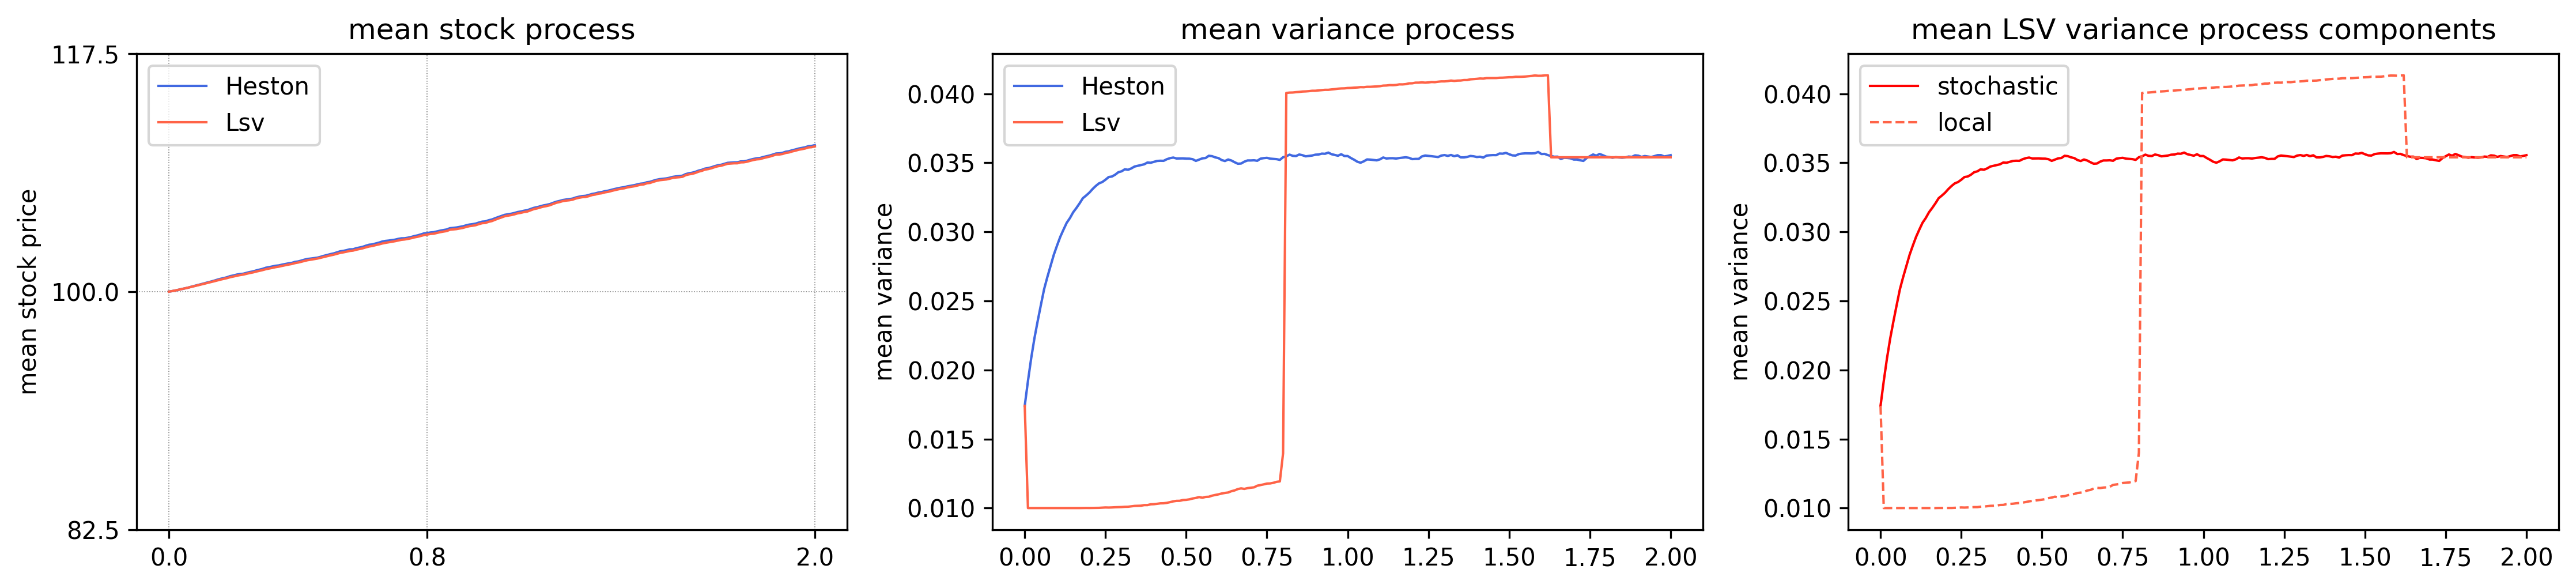

In [49]:
#Plot avarage path for volaitlity:

x_ = np.linspace(0, 2, 2 * 100 + 1)
fig, axs = plt.subplots(1, 3, figsize=(15, 3.5), dpi=300)  # Adjust the size as needed

axs[0].plot(x_, np.mean(pure_stock, axis=0), label='Heston', color = 'royalblue', linewidth=1)
axs[0].plot(x_, np.mean(bump_stock, axis=0), label='Lsv',  color = 'tomato', linewidth=1)
axs[0].legend()
axs[0].set_title('mean stock process')  
axs[0].set_ylabel('mean stock price') 
axs[0].set_xticks([0, 0.8, 2])
axs[0].set_yticks([82.5, 100, 117.5])
axs[0].grid(color = 'grey', linestyle = ':', linewidth = 0.4)

# Second subplot
axs[1].plot(x_, np.mean(pure_vols, axis=0), label='Heston', color = 'royalblue',linewidth=1)
axs[1].plot(x_, np.mean(bump_lsv_vol, axis=0), label='Lsv',  color = 'tomato', linewidth=1)
axs[1].legend()
axs[1].set_title('mean variance process') 
axs[1].set_ylabel('mean variance') 

# Third subplot
axs[2].plot(x_, np.mean(bump_EV, axis=0), label='stochastic', color = 'red', linewidth=1)
axs[2].plot(x_, np.mean(bump_Vloc, axis=0),'--', label='local', color = 'tomato', linewidth=1)

axs[2].legend()
axs[2].set_title('mean LSV variance process components') 
axs[2].set_ylabel('mean variance')
plt.tight_layout()
plt.savefig("avg_path.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 5. Heston LSV simulation with continuous Local volatility surface

In [213]:
#MODEL: 
params = [0.3,  1,  0.03,  0.0174, -0.3]
qe_params = [1.50, 0.50, 0.50]
model = heston.Heston(params, 100, 0.05, qe_params)

#PROVIDE PRICING:
target_grid.prices = model.analytic_price(target_grid.strikes, target_grid.maturities, True, 'lewis')
target_grid.calculate_iv(0.05)

In [214]:
#CREATE SURFACE OBJECT: 
tsurface = surface.Surface(target_grid, 0.05)
tsurface.set_interpolant('splines', 'iv', 10)
st = np.linspace(60, 140, 100)
mt = np.linspace(0.3, 2, 100)

#Interpolation nodes: 
ST, MT = np.meshgrid(st, mt)

# Evaluate the interpolating function on the new grid
iv = tsurface.implied_volatility(ST, MT)
lv = tsurface.local_volatility(ST, MT, 'iv')

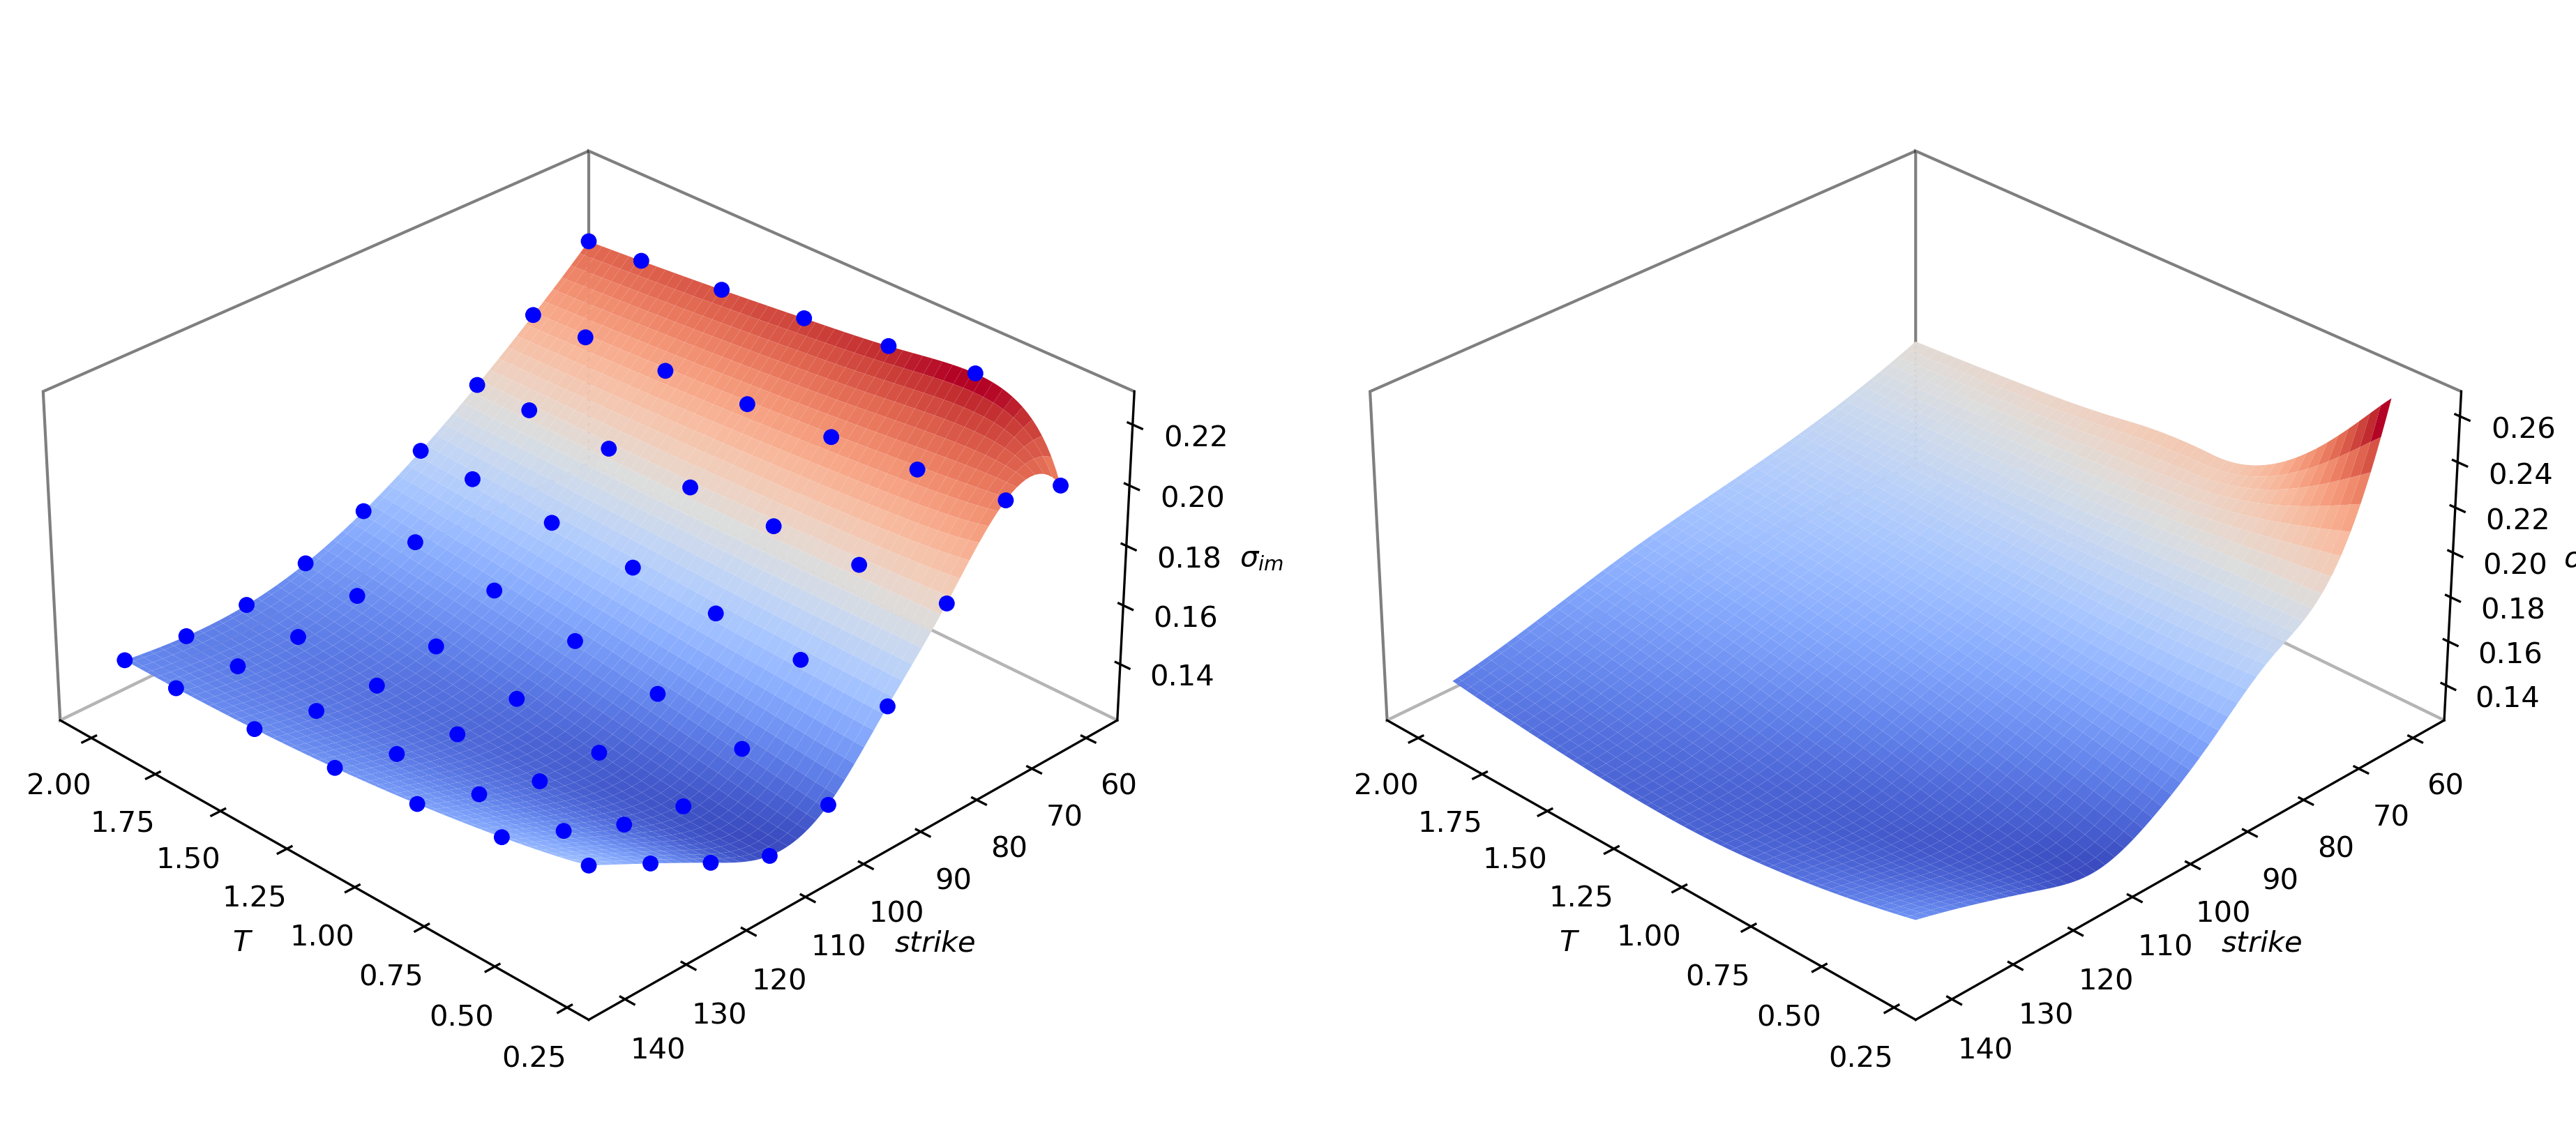

In [215]:
#Plot implied volaitlity and local volatility surface:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(15, 9), dpi=300) 

#Plot settings for ax
axs[0].set_xlabel(r'$T$')
axs[0].set_ylabel(r'$strike$')
axs[0].set_zlabel(r'$\sigma_{im}$')
axs[0].plot_surface(MT, ST, iv, cmap='coolwarm', alpha=1, label = 'cubic_spline')
axs[0].scatter3D(target_grid.maturities, target_grid.strikes, target_grid.iv, color = 'blue', alpha=1, label = 'model_data')

axs[0].xaxis.set_rotate_label(False)
axs[0].yaxis.set_rotate_label(False)
axs[0].zaxis.set_rotate_label(False)

axs[0].view_init(elev = 30, azim = 135)
axs[0].grid(False)
axs[0].xaxis.pane.set_edgecolor('black')
axs[0].yaxis.pane.set_edgecolor('black')
axs[0].xaxis.pane.fill = False
axs[0].yaxis.pane.fill = False
axs[0].zaxis.pane.fill = False
axs[0].set_box_aspect(aspect = (2,2,1))

axs[1].set_xlabel(r'$T$')
axs[1].set_ylabel(r'$strike$')
axs[1].set_zlabel(r'$\sigma_{loc}$')
axs[1].plot_surface(MT, ST, lv, cmap='coolwarm', alpha=1, label = 'cubic_spline')

axs[1].xaxis.set_rotate_label(False)
axs[1].yaxis.set_rotate_label(False)
axs[1].zaxis.set_rotate_label(False)

axs[1].view_init(elev = 30, azim = 135)
axs[1].grid(False)
axs[1].xaxis.pane.set_edgecolor('black')
axs[1].yaxis.pane.set_edgecolor('black')
axs[1].xaxis.pane.fill = False
axs[1].yaxis.pane.fill = False
axs[1].zaxis.pane.fill = False
axs[1].set_box_aspect(aspect = (2,2,1))

plt.show()

In [247]:
#CREATE MODEL 
params = [0.3,  1,  0.03,  0.0174, -0.3]
qe_params = [1.50, 0.50, 0.50]

#set local volatilitties
grid_loc = grid.Grid()
st = np.linspace(0.6, 1.4, 40)
mt = np.linspace(0.3, 2, 40)
grid_loc.fixed_grid_generate(st, mt, 100)
local_volatility = tsurface.local_volatility(grid_loc.strikes, grid_loc.maturities, 'iv')
bump = np.vstack((grid_loc.strikes, grid_loc.maturities, local_volatility))

#set bins for E(Vt|S = St) approximation
bins = np.linspace(50, 160, 40)

#CREATE MODEL
lsv_model = heston_lsv.HestonLSV(params, 100, 0.05, qe_params, bins)
lsv_model.set_bump(bump)

#PROVIDE PRICING
#without bump:
model = heston.Heston(params, 100, 0.05, qe_params)
pure_stock, pure_vols = model.euler_scheme(N = 10_000, T = 2, n = 100, seed_ = 1965)

#with bump:
bump_stock, bump_vols, bump_EV, bump_Vloc, bump_lsv_vol = LSV_simulation_euler(bump, bins, params, s0 = 100, r = 0.05, N = 10_000, T = 2, n = 100, seed_ = 1965)

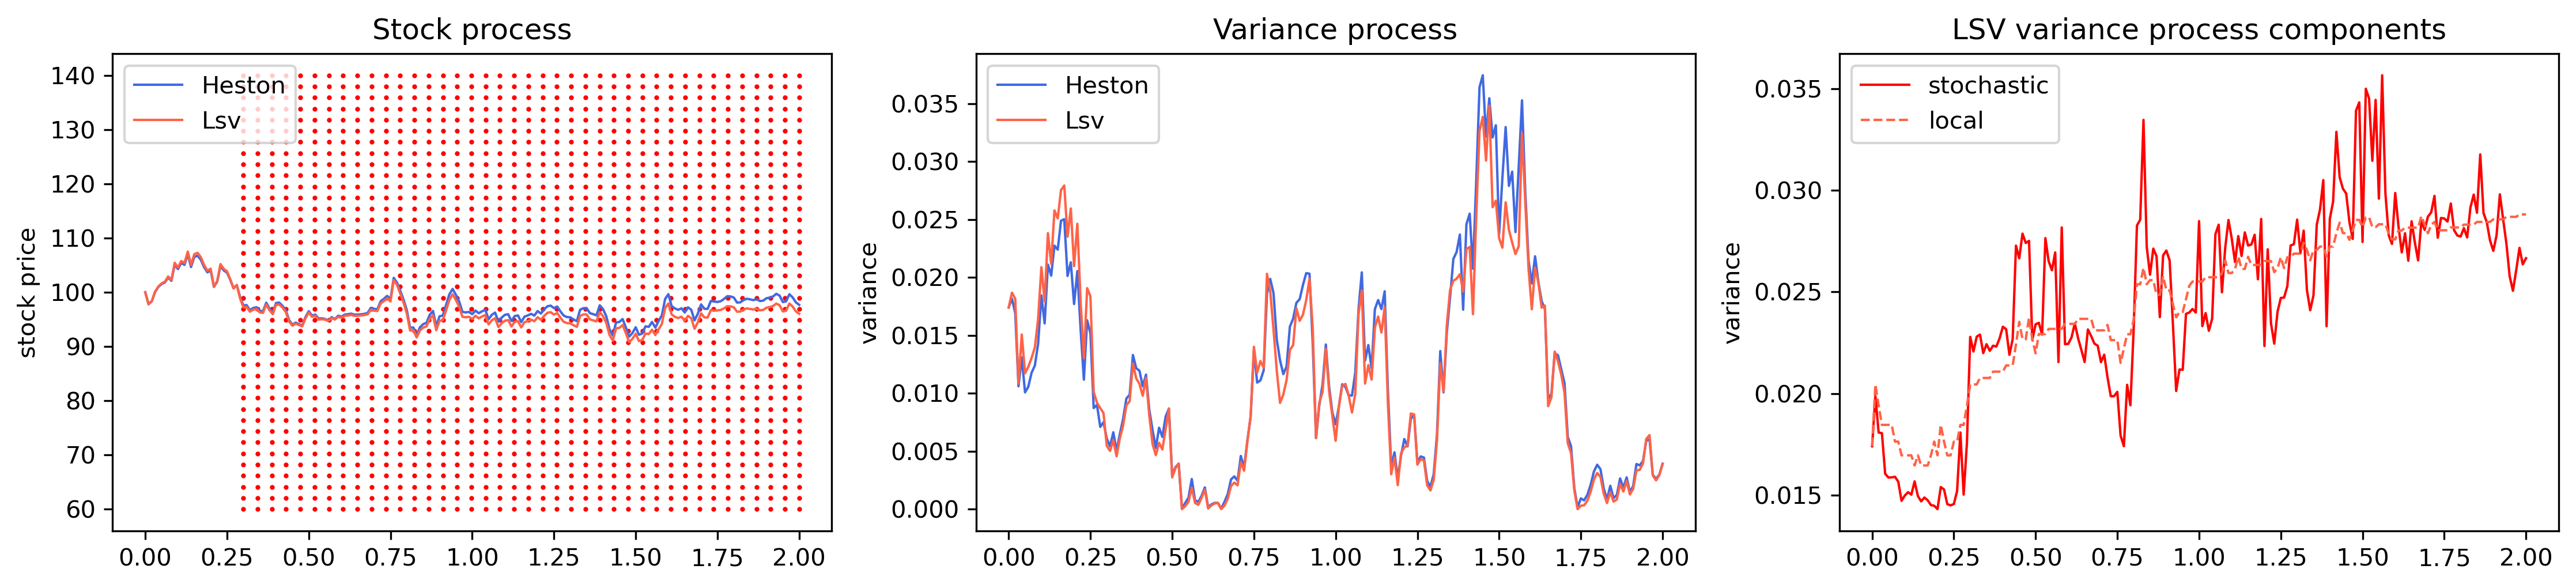

In [248]:
#Plot sample paths using the contineous local volaitlity surface:
x_ = np.linspace(0, 2, 2 * 100 + 1)
i = 4

# Creating figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 3.5), dpi=300)  # Adjust the size as needed
axs[0].plot(x_, pure_stock[i], label='Heston', color = 'royalblue', linewidth=1)
axs[0].plot(x_, bump_stock[i], label='Lsv',  color = 'tomato', linewidth=1)
axs[0].legend()
axs[0].set_title('Stock process')  
axs[0].set_ylabel('stock price') 
axs[0].scatter(grid_loc.maturities, grid_loc.strikes, label = 'loval volatiltiy', c = 'r', s=1)
#axs[0].grid(color = 'grey', linestyle = ':', linewidth = 0.4)

# Second subplot
axs[1].plot(x_, pure_vols[i], label='Heston', color = 'royalblue',linewidth=1)
axs[1].plot(x_, bump_lsv_vol[i], label='Lsv',  color = 'tomato', linewidth=1)
axs[1].legend()
axs[1].set_title('Variance process') 
axs[1].set_ylabel('variance') 

axs[2].plot(x_, bump_EV[i], label='stochastic', color = 'red', linewidth=1)
axs[2].plot(x_, bump_Vloc[i],'--', label='local', color = 'tomato', linewidth=1)

axs[2].legend()
axs[2].set_title('LSV variance process components') 
axs[2].set_ylabel('variance')
plt.tight_layout()
plt.savefig("surface_path.pdf", format="pdf", bbox_inches="tight")
plt.show()